In [1]:
from src.thickness_dataset import ThicknessDataset, ToTensor
from src.models import U_Net
from src.resnet import ResNet
from src.trainer import Trainer

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2
PATH = "data\gen_data_6000_v2"


augs = A.Compose([A.Normalize(mean = (0, 0, 0),
                              std  = (1, 1, 1)),
                 ToTensorV2()])
thickness_dataset = ThicknessDataset(PATH,  transform=augs)

# https://kozodoi.me/python/deep%20learning/pytorch/tutorial/2021/03/08/image-mean-std.html Could be worth attempting to normalise the data
# https://stackoverflow.com/questions/41428868/image-preprocessing-in-deep-learning

In [2]:
idx = 0 
sample = thickness_dataset[idx]

print("cam_pos: ", sample['cam_pos'])
print("catagory: ", sample['catagory'])
print("model_id: ", sample['model_id'])
print("sample_no: ", sample['sample_no'])

img = sample['img']
vis = sample['depth_map'].reshape(128,128)
# vis = vis[np.nonzero(vis)]

# print(img.shape)
# img = img.numpy().transpose(1, 2, 0)

# # Displays ehhe
# fig = plt.figure(figsize=(8,6))
# ax = fig.add_subplot()
# ax.imshow(vis)

# plt.title(f"{sample['catagory']}, {sample['model_id']}, {sample['sample_no']}")
# plt.show()

cam_pos:  [ 1.27875577  1.78995832 -1.17304301]
catagory:  airplane,aeroplane,plane
model_id:  172764bea108bbcceae5a783c313eb36
sample_no:  frame_0


In [3]:
# Calculate mean and std
image_loader = DataLoader(thickness_dataset, 
                          batch_size  = 128, 
                          shuffle     = False, 
                          num_workers = 4,
                          pin_memory  = True)

# placeholders
psum    = torch.tensor([0.0, 0.0, 0.0])
psum_sq = torch.tensor([0.0, 0.0, 0.0])

# loop through images
for inputs in tqdm(image_loader):
    psum    += inputs['img'].sum(axis        = [0, 2, 3])
    psum_sq += (inputs['img'] ** 2).sum(axis = [0, 2, 3])

# pixel count
count = len(thickness_dataset) * 128 * 128

# mean and std
total_mean = psum / count
total_var  = (psum_sq / count) - (total_mean ** 2)
total_std  = torch.sqrt(total_var)

100%|██████████| 52/52 [00:31<00:00,  1.64it/s]


In [4]:
augs = A.Compose([A.Normalize(mean = total_mean,
                              std  = total_std),
                 ToTensorV2()])
thickness_dataset = ThicknessDataset(PATH, transform=augs)

cam_pos:  [-1.04458646  1.01652035  1.40237131]
catagory:  bowl
model_id:  429a622eac559887bbe43d356df0e955
sample_no:  frame_0
torch.Size([3, 128, 128])


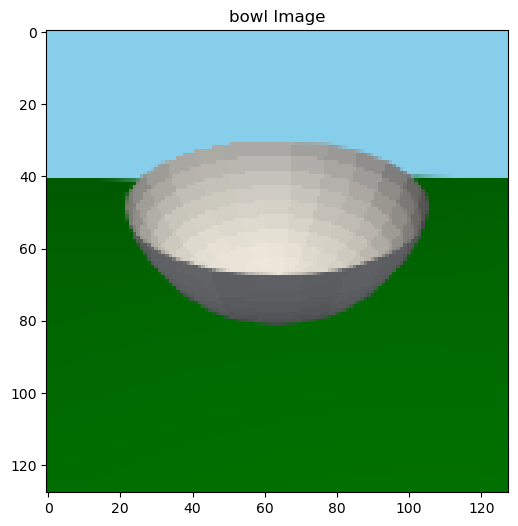

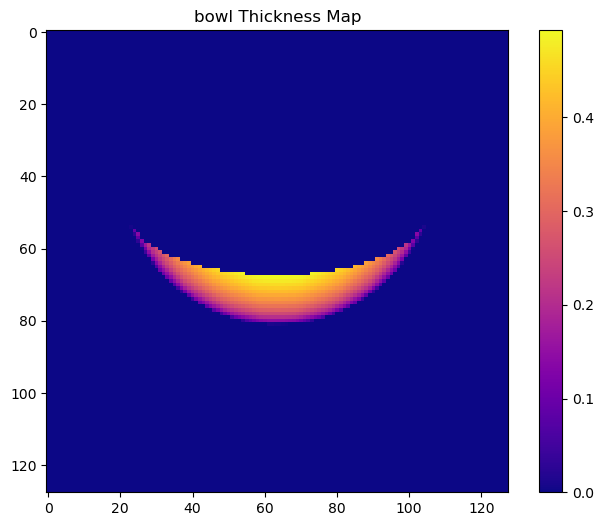

In [22]:
import cv2
idx = 1002
sample = thickness_dataset[idx]

print("cam_pos: ", sample['cam_pos'])
print("catagory: ", sample['catagory'])
print("model_id: ", sample['model_id'])
print("sample_no: ", sample['sample_no'])

img = sample['img']
print(img.shape)
img_loc = sample['img_loc']
img = cv2.cvtColor(cv2.imread(img_loc), cv2.COLOR_BGR2RGB)

# Displays ehhe
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot()
ax.imshow(img)
plt.title(f"{sample['catagory']} Image")
plt.show()
# fig.savefig("img.pdf")
# plot depth map

vis = sample['thick_map'].reshape(128,128)
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot()
cls =ax.imshow(vis, cmap='plasma')
plt.title(f"{sample['catagory']} Thickness Map")
plt.colorbar(cls)
plt.show()
# fig.savefig("thickmap.pdf")

In [19]:
from torch.utils.data import DataLoader, Subset

def customRandomSplit(dataset, train_size, val_size, test_size):
    # TODO: DONT think its adding in the indices +1 and +2 need to add that to all the indices arrays
    rnd_Seed=42
    mandatory_test_models = ["88d183f319cddb7344221bef0fa3c36b","ce40b134b11e8c822bbc2c380e91dfe2","67bc9bec05f78850f9e08161aea27d2f","ba494b33be3a3e0dc1bbb501b1d87871","15cc3d9020384e8d6e09a8e31c7575c5","bc6a3fa659dd7ec0c62ac18334863d36","46dbba829a57ace8cffd61677456447e","1d527bbed4d12817fa3bb91f4e3cd35f","f400eb5421283e8a102f4912aece242b","899af991203577f019790c8746d79a6f"]
    data_len = len(dataset)
    train_size = int(round((train_size * data_len)/3))
    val_size   = int(round((val_size * data_len)/3))
    test_size  = int(round((test_size * data_len)/3))

    assert train_size*3 + val_size*3 + test_size*3 == data_len, "The split sizes do not add up to the dataset size"
    # Using pytorch subsets to split the dataset
    # 3 is the number of frames per model
    # randomly sample indices for the train size
    choices = np.arange(0, data_len, 3, dtype=int)
    # get the index numbers for the mandatory test models from dataset dataframe
    mandatory_test_indices = []
    for i in range(len(mandatory_test_models)):
        mandatory_test_indices.append(thickness_dataset.dataframe[thickness_dataset.dataframe["model_id"] == mandatory_test_models[i]].index[0])
    mandatory_test_indices = np.array(np.array(mandatory_test_indices), dtype=int)
    # remove the values in mandatory_test_indices from the choices
    choices = np.setdiff1d(choices, mandatory_test_indices)
    
    np.random.seed(rnd_Seed)
    np.random.shuffle(choices)
    # randomly sample indices for the train size
    train_indices = choices[:train_size]
    # randomly sample indices for the val size
    val_indices = choices[train_size:train_size+val_size]
    # randomly sample indices for the test size
    test_indices = choices[train_size+val_size:train_size+val_size+test_size]
    # add the mandatory test indices to the test indices
    test_indices = np.concatenate((test_indices, mandatory_test_indices))
    # final check the values in mandatory_test_indices are in test_indices
    assert np.all(np.isin(mandatory_test_indices, test_indices)), "The mandatory test indices are not in the test indices"
    # check mandatory_test_indices values arent in the other 2
    assert np.all(np.isin(mandatory_test_indices, train_indices)) == False, "The mandatory test indices are in the train indices"
    assert np.all(np.isin(mandatory_test_indices, val_indices)) == False, "The mandatory test indices are in the val indices"


    train_indices = np.concatenate((train_indices, train_indices+1, train_indices+2))
    val_indices = np.concatenate((val_indices, val_indices+1, val_indices+2))
    test_indices = np.concatenate((test_indices, test_indices+1, test_indices+2))
    # no intersections between the sets
    it = np.intersect1d(train_indices, val_indices)
    it2 = np.intersect1d(train_indices, test_indices)
    it3 = np.intersect1d(val_indices, test_indices)
    assert len(it) == 0 , f"The train and val sets have the same indices {it}"
    assert len(it2) == 0 , f"The train and test sets have the same indices {it2}"
    assert len(it3) == 0 , f"The val and test sets have the same indices{it3}"
    
    # create the subsets
    train_set = Subset(dataset, train_indices)
    val_set   = Subset(dataset, val_indices,)
    test_set  = Subset(dataset, test_indices)
    assert len(train_set) + len(val_set) + len(test_set) == data_len, "The split sizes do not add up to the dataset size"
    return train_set, val_set, test_set

In [20]:
train_split = 0.7
valid_split = 0.1
test_split = 0.2
train_dataset, valid_dataset, test_dataset = customRandomSplit(thickness_dataset, train_split, valid_split, test_split)

In [21]:
batch_size = 16 # 16

train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

In [22]:
# model = ResNet()

model = U_Net()

epochs = 200
learning_rate = 2e-4
scheduler = None
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, verbose=True)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.0005)
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0005)

loss_fn = nn.MSELoss()

trainer = Trainer(model, optimizer, loss_fn, train_dataloader, valid_dataloader, scheduler=scheduler)
trained_model = trainer.run(epochs)

Using cuda device


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Finished Epoch: 0 | Train Masked Loss: 0.01982 | Train Loss: 0.00351 | Val  Masked Loss: 0.01094 | Val Loss: 0.00156
Finished Epoch: 1 | Train Masked Loss: 0.01183 | Train Loss: 0.00158 | Val  Masked Loss: 0.01411 | Val Loss: 0.00172
Finished Epoch: 2 | Train Masked Loss: 0.01116 | Train Loss: 0.00147 | Val  Masked Loss: 0.01492 | Val Loss: 0.00216
Finished Epoch: 3 | Train Masked Loss: 0.01095 | Train Loss: 0.00145 | Val  Masked Loss: 0.01590 | Val Loss: 0.02711
Finished Epoch: 4 | Train Masked Loss: 0.01087 | Train Loss: 0.00143 | Val  Masked Loss: 0.01152 | Val Loss: 0.00140
Finished Epoch: 5 | Train Masked Loss: 0.01047 | Train Loss: 0.00136 | Val  Masked Loss: 0.01012 | Val Loss: 0.00149
Finished Epoch: 6 | Train Masked Loss: 0.01017 | Train Loss: 0.00133 | Val  Masked Loss: 0.00909 | Val Loss: 0.00124
Finished Epoch: 7 | Train Masked Loss: 0.01036 | Train Loss: 0.00135 | Val  Masked Loss: 0.00982 | Val Loss: 0.00137
Finished Epoch: 8 | Train Masked Loss: 0.01045 | Train Loss: 0.0

Using cuda device


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


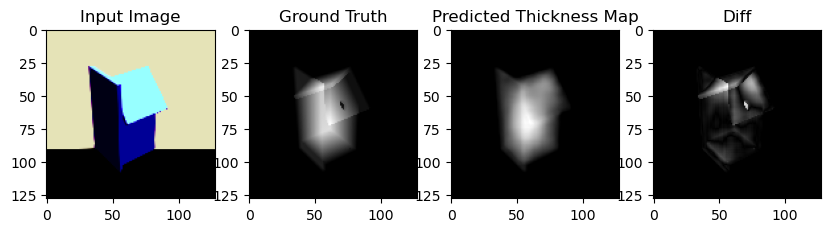

In [24]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))
trained_model=model
trained_model.eval()


with torch.no_grad():
    data = iter(test_dataloader).next()
    image, label = data['img'].to(device, dtype=torch.float), data['thick_map'].to(device, dtype=torch.float)
    output = trained_model(image)
    image = image.cpu().numpy().transpose(0,2,3,1)
    label = label.cpu().numpy()
    output = output.cpu().numpy()

    plt.figure(figsize=(10,10))
    plt.subplot(1,4,1)
    plt.imshow(image[0], cmap='gray')
    plt.title('Input Image')
    plt.subplot(1,4,2)
    plt.imshow(label[0].reshape(128,128), cmap='gray')
    plt.title('Ground Truth')
    plt.subplot(1,4,3)
    plt.imshow(output[0].reshape(128,128), cmap='gray')
    plt.title('Predicted Thickness Map')
    plt.subplot(1,4,4)
    plt.imshow(abs(label[0]-output[0]).reshape(128,128), cmap='gray')
    plt.title('Diff')
    plt.show()

